In [86]:
import os
import numpy as np
import librosa

# 設定常數
DATA_PATH = 'data'  # 請替換為您的音訊數據路徑
SAMPLE_RATE = 16000
FIXED_DURATION = 2.0  # 秒
FIXED_LENGTH = int(SAMPLE_RATE * FIXED_DURATION)
N_MELS = 64
N_FFT = 1024
HOP_LENGTH = 512

# 獲取音訊文件列表
def get_audio_files(data_path):
    classes = ['swallow', 'non']
    file_paths = []
    labels = []
    for idx, cls in enumerate(classes):
        cls_path = os.path.join(data_path, cls)
        for file_name in os.listdir(cls_path):
            if file_name.endswith('.wav'):
                file_paths.append(os.path.join(cls_path, file_name))
                labels.append(idx)
    return file_paths, labels

file_paths, labels = get_audio_files(DATA_PATH)
print(f"共找到 {len(file_paths)} 個音訊文件。")


共找到 81 個音訊文件。


In [87]:
# 預處理和特徵提取
def preprocess_audio(file_path):
    # 加載音訊
    audio, sr = librosa.load(file_path, sr=SAMPLE_RATE)
    
    # 確保音訊長度一致
    if len(audio) < FIXED_LENGTH:
        pad_width = FIXED_LENGTH - len(audio)
        audio = np.pad(audio, (0, pad_width), mode='constant')
    else:
        audio = audio[:FIXED_LENGTH]
    
    # 正規化振幅
    max_abs_amplitude = np.max(np.abs(audio))
    if max_abs_amplitude > 0:
        audio = audio / max_abs_amplitude
    
    # 提取梅爾頻譜圖
    mel_spectrogram = librosa.feature.melspectrogram(
        y=audio,
        sr=sr,
        n_fft=N_FFT,
        hop_length=HOP_LENGTH,
        n_mels=N_MELS
    )
    # 對數壓縮
    log_mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)
    
    # 標準化
    mean = np.mean(log_mel_spectrogram)
    std = np.std(log_mel_spectrogram)
    standardized_feature = (log_mel_spectrogram - mean) / std
    
    return standardized_feature


In [88]:
import tensorflow as tf
from sklearn.model_selection import train_test_split

# 提取特徵
features = []
for file_path in file_paths:
    feature = preprocess_audio(file_path)
    features.append(feature)

features = np.array(features)
labels = np.array(labels)

# 確認形狀
print("特徵形狀：", features.shape)
print("標籤形狀：", labels.shape)

# 添加通道維度
features = features[..., np.newaxis]

# 划分數據集
X_train, X_temp, y_train, y_temp = train_test_split(
    features, labels, test_size=0.3, random_state=42, stratify=labels)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

print("訓練集形狀：", X_train.shape)
print("驗證集形狀：", X_val.shape)
print("測試集形狀：", X_test.shape)


特徵形狀： (81, 64, 63)
標籤形狀： (81,)
訓練集形狀： (56, 64, 63, 1)
驗證集形狀： (12, 64, 63, 1)
測試集形狀： (13, 64, 63, 1)


In [89]:
from tensorflow.keras import layers, models

# 自訂 Transformer 編碼器層
class TransformerBlock(layers.Layer):
    def __init__(self, num_heads, key_dim, ff_dim, rate=0.1, **kwargs):
        super(TransformerBlock, self).__init__(**kwargs)
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=key_dim)
        self.ffn = models.Sequential([
            layers.Dense(ff_dim, activation='relu'),
            layers.Dense(key_dim)
        ])
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)
    
    def call(self, inputs, training=None):
        # 注意力機制
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        
        # 前饋神經網絡
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)
    
    def get_config(self):
        config = super(TransformerBlock, self).get_config()
        config.update({
            'num_heads': self.att.num_heads,
            'key_dim': self.att.key_dim,
            'ff_dim': self.ffn.layers[0].units,
            'rate': self.dropout1.rate,
        })
        return config
    
    @classmethod
    def from_config(cls, config):
        return cls(**config)
def build_model(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)
    
    # 卷積層
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = layers.MaxPooling2D((2, 2))(x)
    
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    
    # 展平
    shape = x.shape
    x = layers.Reshape((shape[1] * shape[2], shape[3]))(x)
    
    # Transformer 層
    transformer_block = TransformerBlock(num_heads=4, key_dim=64, ff_dim=128)
    x = transformer_block(x, training=True)
    
    # 全局平均池化
    x = layers.GlobalAveragePooling1D()(x)
    
    # 輸出層
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    
    model = models.Model(inputs=inputs, outputs=outputs)
    return model

# 模型設定
input_shape = X_train.shape[1:]
num_classes = len(np.unique(y_train))

model = build_model(input_shape, num_classes)
model.summary()



Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_14 (InputLayer)     │ (None, 64, 63, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 64, 63, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 32, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 32, 31, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 16, 15, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_7 (Reshape)             │ (None, 240, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_7             │ (None, 240, 64)        │        83,200 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_7      │ (None, 64)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 102,146 (399.01 KB)

 Trainable params: 102,146 (399.01 KB)

 Non-trainable params: 0 (0.00 B)

In [105]:
from tensorflow.keras import optimizers, losses, metrics

# 編譯模型
model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-4),
    loss=losses.SparseCategoricalCrossentropy(),
    metrics=[metrics.SparseCategoricalAccuracy()]
)

# 訓練模型
history = model.fit(
    X_train, y_train,
    epochs=35,
    batch_size=32,
    validation_data=(X_val, y_val)
)


Epoch 1/35
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 194ms/step - loss: 0.1704 - sparse_categorical_accuracy: 0.9286 - val_loss: 0.3633 - val_sparse_categorical_accuracy: 0.9167
Epoch 2/35
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.1180 - sparse_categorical_accuracy: 0.9881 - val_loss: 0.1623 - val_sparse_categorical_accuracy: 0.9167
Epoch 3/35
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.1134 - sparse_categorical_accuracy: 0.9539 - val_loss: 0.2467 - val_sparse_categorical_accuracy: 0.9167
Epoch 4/35
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.0696 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.3810 - val_sparse_categorical_accuracy: 0.8333
Epoch 5/35
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.1108 - sparse_categorical_accuracy: 0.9881 - val_loss: 0.3398 - val_sparse_categorical_accuracy: 0.8333
Epoch 6/35
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0887 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.2193 - val_sparse_categorical_accuracy: 0.9167
Epoch 7/35
2/2 ━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.2612 - sparse_categorical_accuracy: 0.9231
測試集準確率：0.9231


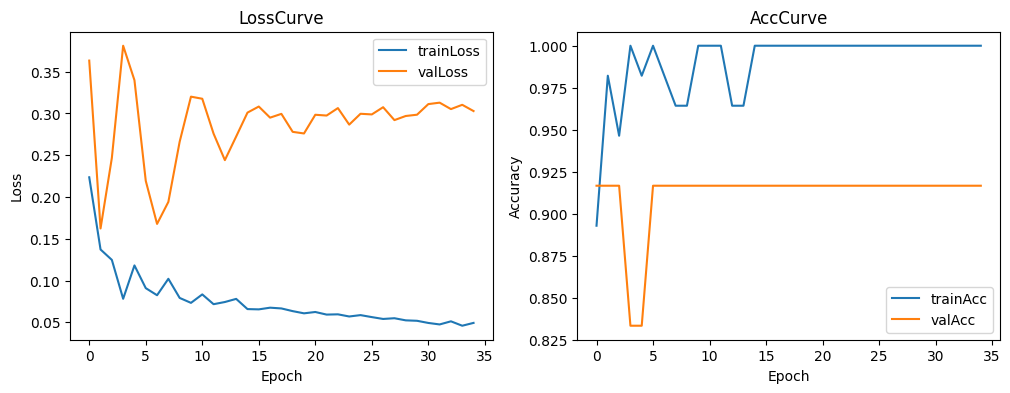

In [106]:
# 在測試集上評估模型
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"測試集準確率：{test_acc:.4f}")

# 繪製訓練曲線
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

# 繪製損失曲線
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='trainLoss')
plt.plot(history.history['val_loss'], label='valLoss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('LossCurve')
plt.legend()

# 繪製準確率曲線
plt.subplot(1, 2, 2)
plt.plot(history.history['sparse_categorical_accuracy'], label='trainAcc')
plt.plot(history.history['val_sparse_categorical_accuracy'], label='valAcc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('AccCurve')
plt.legend()

plt.show()


In [96]:
# MODEL_SAVE_PATH = "model/audioModel.keras"
# model.save(MODEL_SAVE_PATH)
# MODEL_SAVE_PATH = "model/audioModel.h5"
# model.save(MODEL_SAVE_PATH)
model.export("savedModel")


FailedPreconditionError: savedModel\variables is not a directory

In [95]:
import tensorflow as tf

MODEL_FILE_PATH = 'model/audioModel.keras'
try:
    model = tf.keras.models.load_model(MODEL_FILE_PATH, custom_objects={'TransformerBlock': TransformerBlock})
    print("模型已成功載入。")
except Exception as e:
    print(f"載入模型時發生錯誤：{e}")



模型已成功載入。
